# Create MBTiles of KyFromAbove Data for External Devices

### Objectives
 - Create MBTiles of an area of interest leveraging KyFromAbove Open Data on AWS

### Steps

 - Create python environment or install necessary modules
 - Set up variables
    - Map Display
    - KyFromAbove Tile Index
    - Area of Interest
 - Create functions
    - Clip tiles to AOI
    - Create a Virtual Raster Tile (VRT) file
    - Create MBTiles of VRT

\**Note: this Notebook was built using Python 3.13.2*

## Import/Install Modules

In [1]:
## Uncomment this section to install the necessary python modules
# %pip install leafmap
# %pip install geopandas
# %pip install fiona
# %pip install gdal==3.10.2
# %pip install xarray
# %pip install rasterio
# %pip install localtileserver

In [2]:
# import modules
import leafmap
from leafmap import basemaps, colormaps, toolbar, read_vector
import geopandas as gpd
import fiona
from osgeo import gdal
import os
import multiprocessing

## Set up variables

### Query Data from Kentucky's Open GIS Portal

Add an AOI.  In instance, I will use the [KyGovMaps Open Data Portal](https://opengisdata.ky.gov/) API to query Casey County from the [Kentucky County Boundaries](https://opengisdata.ky.gov/datasets/ad52760b298b4f2b8879233fecd1acd1_0/explore?location=37.613789%2C-85.768000%2C5.86) as a GeoJSON.

In [3]:
# 3-inch from https://kyraster.ky.gov/arcgis
orthos_3in = 'https://kyraster.ky.gov/arcgis/services/ImageServices/Ky_KYAPED_Phase3_3IN/ImageServer/WMSServer?'

# tile index - grab from ../constants.py file
tile_index = 'https://kyfromabove.s3.us-west-2.amazonaws.com/imagery/orthos/tile-grids/kyfromabove_phase3_aerial_5k_grid.gpkg'

# read tile index
tile_index_layer = read_vector(tile_index)


# Casey County GeoJson
aoi_geojson = 'https://services3.arcgis.com/ghsX9CKghMvyYjBU/arcgis/rest/services/Ky_County_Polygons_WM/FeatureServer/0/query?where=NAME2%3D%27Casey%27&fullText=&objectIds=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=NAME2&returnGeometry=true&returnCentroid=false&returnEnvelope=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&collation=&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnTrueCurves=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson'

# read geojson
aoi_layer = read_vector(aoi_geojson)

# create an output for VRT
# vrt_output_name = input('Tape a name for the VRT output: ')
# vrt_output = f'data/{vrt_output_name}.vrt'
vrt_output = 'data/aoi.vrt'

## Plot a map using Leafmap

In [4]:
# instantiate a map
center = [37.4, -85]
zoom = 10

m = leafmap.Map(center=center, zoom = zoom)

# add imagery to map
m.add_wms_layer(
    url=orthos_3in,
    name='Ky KYAPED Phase3 3IN',
    layers='0',
    attribution='DGI'
)

# add Casey County polygon
m.add_gdf(
    aoi_layer,
    layer_name='Casey County',
    style={
        'color': 'yellow'
    }
)

# add the Tile Index
m.add_gdf(
    tile_index_layer,
    layer_name="Tile Index",
    style = {
        "color": "#336699"
    }
) 

# add some controls
m.add_layer_control(position='topright')
# m.add_minimap(zoom=3, position='bottomright') 

# display map
m

Map(center=[37.4, -85], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

---
## Define functions

 1. Define a function to clip tiles to an AOI

In [5]:
# Define a function that clips tiles to an of interest
def clip_tiles_to_aoi(tiles, aoi):
    # convert to wgs84 for plotting
    tiles = tiles.to_crs('EPSG:4326')
    aoi = aoi.to_crs('EPSG:4326') 
    # clip the tiles to the AOI
    tiles_clipped = gpd.clip(tiles, aoi)
    return tiles_clipped

 2. Create a VRT

In [6]:
def create_vrt(input_list, vrt_output):
    options = gdal.BuildVRTOptions(
       bandList=(1,2,3),
       resampleAlg='nearest',
       outputSRS='EPSG:3857'
    )

    output_vrt = gdal.BuildVRT(
        vrt = gdal.BuildVRT(
            vrt_output,
            input_list
        ) 
    )

    return output_vrt

 3. VRT to MBTiles

In [7]:
def create_mbtiles(vrt, output_mbtiles):
    num_threads = max(multiprocessing.cpu_count() - 1, 1)
    # Set up Translate options
    options = gdal.TranslateOptions(
        bandList=(1, 2, 3),
        format='MBTiles',
        outputSRS='EPSG:3857',
        resampleAlg='nearest',
        creationOptions=[
            'TILE_FORMAT=PNG',
            'COMPRESS=DEFLATE',
            f'NUM_THREADS={num_threads}',
            'QUALITY=75'
        ]
    )

    mbtiles = gdal.Translate(
        output_mbtiles,         
        vrt,                    
        options=options
    )
    return mbtiles


## Run functions

 - clip tiles
 - build VRT\*
 - export MBTiles

 \**this may take several minutes*


<Axes: >

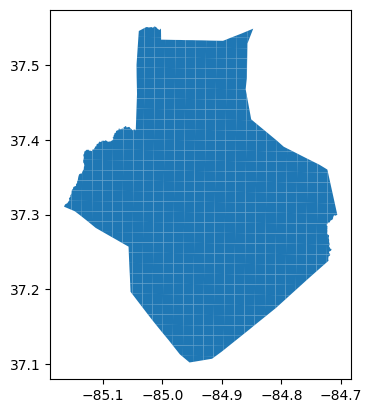

In [8]:
# clip tiles
tiles_aoi = clip_tiles_to_aoi(tile_index_layer, aoi_layer)

tiles_aoi.plot()

In [ ]:
# set up input variables for create_vrt function
data_dir = 'data'                               # set output directory
if not os.path.exists(data_dir):
    os.mkdirs('data')
else:
    print('Data Directory Already Exists')

input_list = tiles_aoi['aws_url'].tolist()      # list of COGs
vrt_output = 'data/casey.vrt'                   # VRT to create

if not os.path.exists(vrt_output):
    vrt = create_vrt(input_list, vrt_output)
else:
    print('VRT Already Exists')

Data Directory Already Exists


In [ ]:
out_mbtiles = 'data/casey.mbtiles'
if not os.path.exists(out_mbtiles):
    mbtiles = create_mbtiles(vrt, out_mbtiles)
else:
    print('MBTiles Already Exists')